In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cosima_cookbook as cc
import UsefulFunctions as uf
import cartopy.crs as ccrs
import cartopy.feature as cft
from glob import glob
import cmocean as cm

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


# Loading ACCESS-OM2-01 sample data

In [2]:
#Starting cookbook session to search for area data
session = cc.database.create_session()
#Load area data
area = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1)
#Correcting longitudes
area = uf.corrlong(area)
#Selecting correct area
area = area.sel(yt_ocean = slice(-71.5,-55), xt_ocean = slice(30, 170))
#Check results
area

<xarray.DataArray 'area_t' (yt_ocean: 356, xt_ocean: 1400)>
dask.array<getitem, shape=(356, 1400), dtype=float32, chunksize=(312, 720), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -71.48 -71.44 -71.39 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2022-04-27
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

# Transform model output to dataframe

In [3]:
area_df = area.to_dataframe().reset_index()
area_df.drop(columns='area_t', inplace=True)
area_df = area_df.round({'yt_ocean': 3, 'xt_ocean': 3})
area_df

,yt_ocean,xt_ocean
0,-71.478,30.05
1,-71.478,30.15
2,-71.478,30.25
3,-71.478,30.35
4,-71.478,30.45
...,...,...
498395,-55.010,169.55
498396,-55.010,169.65
498397,-55.010,169.75
498398,-55.010,169.85


In [4]:
#Getting number of times month has to be repeated
rows_month = area_df.shape[0]

#Bind static variables by row
area_df = pd.concat([area_df, area_df], axis = 0)

#Add a month column to bind data frame
area_df['month'] = [11]*rows_month + [12]*rows_month

#Check results
area_df

,yt_ocean,xt_ocean,month
0,-71.478,30.05,11
1,-71.478,30.15,11
2,-71.478,30.25,11
3,-71.478,30.35,11
4,-71.478,30.45,11
...,...,...,...
498395,-55.010,169.55,12
498396,-55.010,169.65,12
498397,-55.010,169.75,12
498398,-55.010,169.85,12


## Predicted distribution ACCESS-OM2-01 matches observations

In [5]:
mod_match_files = ['../SDM_outputs/GAM/mean_pred_match_obs.csv',
                   '../SDM_outputs/Maxent/Mod_match_obs/reduced_Maxent_model/mean_pred_match_obs.csv', 
                   '../SDM_outputs/RandomForest/Mod_match_obs/mean_pred_match_obs.csv']

In [6]:
def df_ready(file_path, model, df_coords):
    df = pd.read_csv(file_path)
    df['model'] = model
    df = df[['yt_ocean', 'xt_ocean', 'pred', 'month', 'model']]
    df = df_coords.merge(df, on = ['xt_ocean', 'yt_ocean', 'month'], how = 'left')
    return df

In [42]:
gams = df_ready(mod_match_files[0], 'GAM', area_df)
maxent = df_ready(mod_match_files[1], 'Maxent', area_df)
rf = df_ready(mod_match_files[2], 'Random Forest', area_df)
mod_match_obs = pd.concat([gams, maxent, rf])
mod_match_obs

,yt_ocean,xt_ocean,month,pred,model
0,-71.478,30.05,11,NaN,NaN
1,-71.478,30.15,11,NaN,NaN
2,-71.478,30.25,11,NaN,NaN
3,-71.478,30.35,11,NaN,NaN
4,-71.478,30.45,11,NaN,NaN
...,...,...,...,...,...
996795,-55.010,169.55,12,0.085185,Random Forest
996796,-55.010,169.65,12,0.090123,Random Forest
996797,-55.010,169.75,12,0.085185,Random Forest
996798,-55.010,169.85,12,0.095062,Random Forest


In [43]:
da_mod_match_obs = xr.DataArray(data = mod_match_obs.pred.values.reshape(6, 356, 1400),
                  dims = ['month', 'yt_ocean', 'xt_ocean'],
                  coords = {'month': [11, 12, 11, 12, 11, 12],
                      'xt_ocean': area.xt_ocean.values,
                           'yt_ocean': area.yt_ocean.values})

#Calculating ensemble (mean of all model predictions)
da_mean_mod_match_obs = da_mod_match_obs.groupby('month').mean()

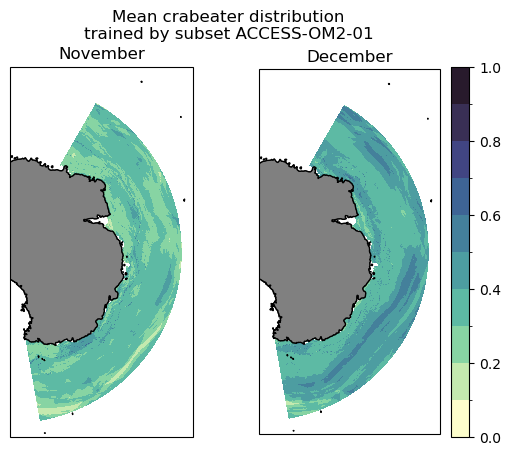

In [50]:
#Initialising figure
fig = plt.figure()

#Getting land mask
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

#Creating projected map
ax1 = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())

#Setting levels for color palette
levels = np.arange(0, 1.1, 0.1)

#Plotting ensemble for November
da_mean_mod_match_obs.sel(month = 11).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels, add_colorbar = False)
ax1.set_title('November')
ax1.add_feature(land)
ax1.coastlines(resolution = '50m')
ax1.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Plotting ensemble for December
ax2 = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
da_mean_mod_match_obs.sel(month = 12).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels)
ax2.set_title('December')
ax2.add_feature(land)
ax2.coastlines(resolution = '50m')
ax2.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Add figure title
plt.suptitle('Mean crabeater distribution\ntrained by subset ACCESS-OM2-01', y = 1.0)

#Saving figure
plt.savefig('../SDM_outputs/ensemble_distribution_mod_match_obs.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

## Predicted distribution ACCESS-OM2-01 full suite

In [31]:
mod_files = ['../SDM_outputs/GAM/mean_pred_mod.csv',
             '../SDM_outputs/Maxent/Mod_full/reduced_Maxent_model/mean_pred_ACCESS.csv',
             '../SDM_outputs/RandomForest/Mod_full/mean_pred_ACCESS.csv']

In [32]:
gams = df_ready(mod_files[0], 'GAM', area_df)
maxent = df_ready(mod_files[1], 'Maxent', area_df)
rf = df_ready(mod_files[2], 'Random Forest', area_df)
mod_pred = pd.concat([gams, maxent, rf])
mod_pred

,yt_ocean,xt_ocean,month,pred,model
0,-71.478,30.05,11,NaN,NaN
1,-71.478,30.15,11,NaN,NaN
2,-71.478,30.25,11,NaN,NaN
3,-71.478,30.35,11,NaN,NaN
4,-71.478,30.45,11,NaN,NaN
...,...,...,...,...,...
996795,-55.010,169.55,12,0.254444,Random Forest
996796,-55.010,169.65,12,0.256667,Random Forest
996797,-55.010,169.75,12,0.252222,Random Forest
996798,-55.010,169.85,12,0.266667,Random Forest


In [51]:
da_mod = xr.DataArray(data = mod_pred.pred.values.reshape(6, 356, 1400),
                  dims = ['month', 'yt_ocean', 'xt_ocean'],
                  coords = {'month': [11, 12, 11, 12, 11, 12],
                      'xt_ocean': area.xt_ocean.values,
                           'yt_ocean': area.yt_ocean.values})

#Calculating ensemble (mean of all model predictions)
da_mean_mod = da_mod.groupby('month').mean()

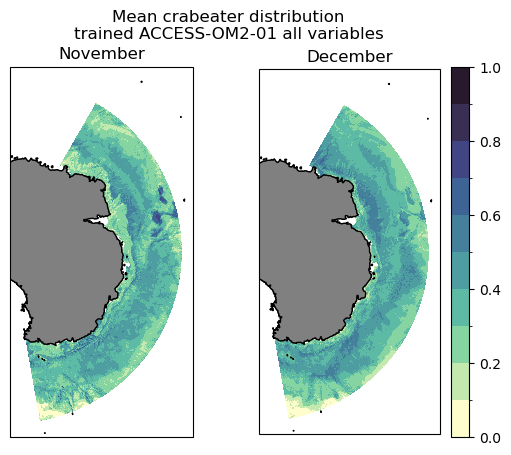

In [53]:
#Initialising figure
fig = plt.figure()

#Getting land mask
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

#Creating projected map
ax1 = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())

#Setting levels for color palette
levels = np.arange(0, 1.1, 0.1)

#Plotting ensemble for November
da_mean_mod.sel(month = 11).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels, add_colorbar = False)
ax1.set_title('November')
ax1.add_feature(land)
ax1.coastlines(resolution = '50m')
ax1.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Plotting ensemble for December
ax2 = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
da_mean_mod.sel(month = 12).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels)
ax2.set_title('December')
ax2.add_feature(land)
ax2.coastlines(resolution = '50m')
ax2.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Add figure title
plt.suptitle('Mean crabeater distribution\ntrained ACCESS-OM2-01 all variables', y = 1.0)

#Saving figure
plt.savefig('../SDM_outputs/ensemble_distribution_access.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

## Predicted distribution observations

In [36]:
obs_files = ['../SDM_outputs/GAM/mean_pred_obs.csv',
             '../SDM_outputs/Maxent/Obs/reduced_Maxent_model/mean_pred_obs.csv',
             '../SDM_outputs/RandomForest/Obs/mean_pred_obs.csv']

In [37]:
gams = df_ready(obs_files[0], 'GAM', area_df)
maxent = df_ready(obs_files[1], 'Maxent', area_df)
rf = df_ready(obs_files[2], 'Random Forest', area_df)
obs_pred = pd.concat([gams, maxent, rf])
obs_pred

,yt_ocean,xt_ocean,month,pred,model
0,-71.478,30.05,11,NaN,NaN
1,-71.478,30.15,11,NaN,NaN
2,-71.478,30.25,11,NaN,NaN
3,-71.478,30.35,11,NaN,NaN
4,-71.478,30.45,11,NaN,NaN
...,...,...,...,...,...
996795,-55.010,169.55,12,0.190123,Random Forest
996796,-55.010,169.65,12,0.192593,Random Forest
996797,-55.010,169.75,12,0.202469,Random Forest
996798,-55.010,169.85,12,0.207407,Random Forest


In [54]:
da_obs = xr.DataArray(data = obs_pred.pred.values.reshape(6, 356, 1400),
                  dims = ['month', 'yt_ocean', 'xt_ocean'],
                  coords = {'month': [11, 12, 11, 12, 11, 12],
                      'xt_ocean': area.xt_ocean.values,
                           'yt_ocean': area.yt_ocean.values})

#Calculating ensemble (mean of all model predictions)
da_mean_obs = da_obs.groupby('month').mean()

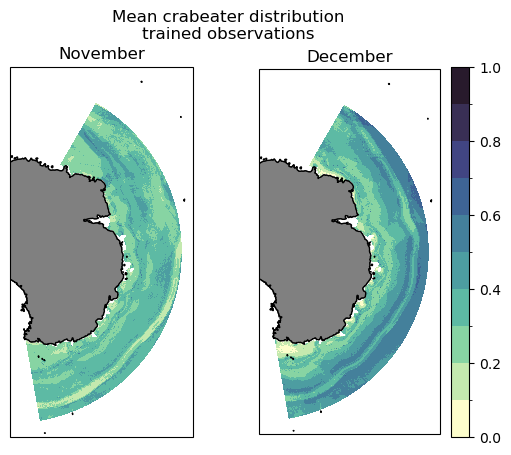

In [55]:
#Initialising figure
fig = plt.figure()

#Getting land mask
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

#Creating projected mpa
ax1 = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())

#Setting levels for color palette
levels = np.arange(0, 1.1, 0.1)

#Plotting ensemble for November
da_mean_obs.sel(month = 11).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels, add_colorbar = False)
ax1.set_title('November')
ax1.add_feature(land)
ax1.coastlines(resolution = '50m')
ax1.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Plotting ensemble for December
ax2 = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
da_mean_obs.sel(month = 12).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels)
ax2.set_title('December')
ax2.add_feature(land)
ax2.coastlines(resolution = '50m')
ax2.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Add figure title
plt.suptitle('Mean crabeater distribution\ntrained observations', y = 1.0)

#Saving figure
plt.savefig('../SDM_outputs/ensemble_distribution_obs.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)